In [124]:
!pip install yfinance
!pip install plotly_express==0.4.0


In [1]:
import yfinance as yahooFinance
import pandas as pd
import numpy as np
import datetime

In [7]:
#Get Tesla Yahoo Finance Historical Data for the past year
TeslaInfo = yahooFinance.Ticker("TSLA")

today = datetime.datetime.now()
one_y = today.replace(year=today.year - 1)

df = TeslaInfo.history(start = one_y, end = today) 
df = df.sort_values(by="Date")
df = df.dropna()

#Create Returns Column
df1 = df.assign(closeDayBef = df.Close.shift(1))
df1['Returns'] = (df.Close - df1.closeDayBef)/(df1.closeDayBef)
#print(df1)

#Create Option Chain
exp = '2022-10-07'
opt = TeslaInfo.option_chain('2022-10-07')
r = opt.calls
print(r)
askprice = r['ask']
print(askprice)

         contractSymbol             lastTradeDate  strike  lastPrice     bid  \
0   TSLA221007C00100000 2022-09-30 19:50:41+00:00   100.0     166.45  164.95   
1   TSLA221007C00110000 2022-09-26 19:44:15+00:00   110.0     167.90  154.75   
2   TSLA221007C00120000 2022-09-29 13:51:37+00:00   120.0     156.95  144.75   
3   TSLA221007C00130000 2022-09-30 15:26:13+00:00   130.0     143.90  134.75   
4   TSLA221007C00140000 2022-09-28 14:14:26+00:00   140.0     140.35  125.00   
..                  ...                       ...     ...        ...     ...   
72  TSLA221007C00570000 2022-09-20 13:30:02+00:00   570.0       0.02    0.00   
73  TSLA221007C00580000 2022-09-23 13:35:03+00:00   580.0       0.01    0.00   
74  TSLA221007C00590000 2022-09-15 16:45:51+00:00   590.0       0.02    0.00   
75  TSLA221007C00600000 2022-09-23 19:12:53+00:00   600.0       0.01    0.00   
76  TSLA221007C00610000 2022-09-29 14:25:51+00:00   610.0       0.01    0.00   

       ask     change  percentChange  v

In [8]:
import math
from scipy.stats import norm
from math import *

# S = Current Stock Price
# K = Option Strike Price
# T = Time until option expiry (in stock days)
# r = Risk free interest rate
# sigma = annual volatility of the returns of the stock
# C is Calculated Call Option Price

def black_scholes(S, K, T, r, sigma):
    #d1 = np.log(S/(K/(1 + r)**T)/(sigma*sqrt(T))) + (sigma*sqrt(T))/2
    d1 = (np.log(S/K) + (r + ((sigma**2)/2))*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    #return S * norm.cdf(d1) - (K/(1 + r)**T) * norm.cdf(d2)
    
    #d1 = (np.log(S/K)+(r+sigma**2/2.)*T)/(sigma*sqrt(T))
    #d2 = d1 - sigma * np.sqrt(T)
    #calls
    return S * norm.cdf(d1) - K*exp(-r * T) * norm.cdf(d2)
    
# Calculate Volatility (sigma)
sigma = np.sqrt(252) * df1['Returns'].std()

In [11]:
# Open list for BS Estimates
bs_estimates = []

for i in range(0,77):
    c_value = black_scholes(S = 275.33,
                            r = 0.69, 
                            K = r['strike'][i], 
                            T = (datetime.datetime.strptime('2022-10-07', "%Y-%m-%d") - 
                                 datetime.datetime.now()).days / 365, 
                            sigma = sigma)
    bs_estimates.append(c_value)

# Format and merge Actual with BS Estimated dataframe

bs_list = pd.DataFrame(data = bs_estimates, index = r.index)
bs_list['Black Scholes Estimate'] = bs_list[0]
del bs_list[0]
df_estimate = r.merge(bs_list, right_index = True, left_index = True)

pd.set_option('display.max_rows', None)
df_estimate.dropna()

print(df_estimate)
        

         contractSymbol             lastTradeDate  strike  lastPrice     bid  \
0   TSLA221007C00100000 2022-09-30 19:50:41+00:00   100.0     166.45  164.95   
1   TSLA221007C00110000 2022-09-26 19:44:15+00:00   110.0     167.90  154.75   
2   TSLA221007C00120000 2022-09-29 13:51:37+00:00   120.0     156.95  144.75   
3   TSLA221007C00130000 2022-09-30 15:26:13+00:00   130.0     143.90  134.75   
4   TSLA221007C00140000 2022-09-28 14:14:26+00:00   140.0     140.35  125.00   
5   TSLA221007C00150000 2022-09-30 19:52:48+00:00   150.0     116.25  115.25   
6   TSLA221007C00160000 2022-09-30 18:49:38+00:00   160.0     106.75  105.10   
7   TSLA221007C00170000 2022-09-30 19:19:03+00:00   170.0      97.12   95.00   
8   TSLA221007C00180000 2022-09-27 18:13:44+00:00   180.0      99.20   84.45   
9   TSLA221007C00190000 2022-09-30 19:19:03+00:00   190.0      77.21   74.90   
10  TSLA221007C00200000 2022-09-30 19:59:13+00:00   200.0      65.50   65.40   
11  TSLA221007C00205000 2022-09-30 16:11

In [12]:
# Compare estimate with actual by calculating error
estimate = df_estimate['Black Scholes Estimate']
df_estimate['Black Scholes Estimate Error'] = ((askprice - estimate)/estimate)*100
estimate_error = df_estimate['Black Scholes Estimate Error']
df_estimate['Black Scholes Estimate Error'].describe()

count    7.700000e+01
mean     4.805986e+22
std      3.803635e+23
min     -3.937893e+01
25%     -2.235119e+01
50%      7.358534e-01
75%      7.631404e+07
max      3.325491e+24
Name: Black Scholes Estimate Error, dtype: float64

/Users/ayush/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    7.700000e+01
mean     4.805986e+22
std      3.803635e+23
min     -3.937893e+01
25%     -2.235119e+01
50%      7.358534e-01
75%      7.631404e+07
max      3.325491e+24
Name: Black Scholes Estimate Error, dtype: float64

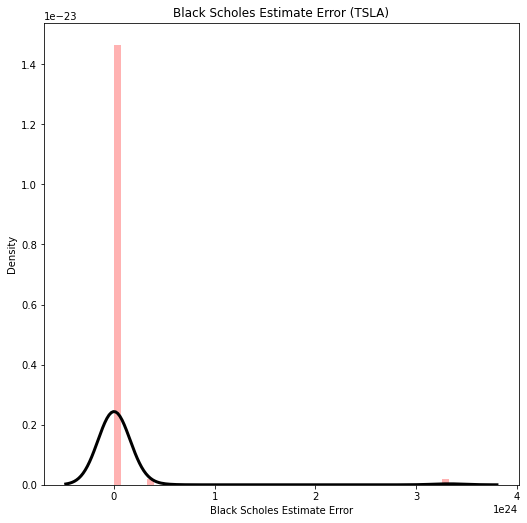

In [13]:
# Throw the Error on a graph
import seaborn as sns
from matplotlib import pyplot as plt

ax = plt.subplots(figsize=(8.5,8.5)),
ax = sns.distplot(estimate_error, label = "Estimate Error x Density",
                  kde_kws={"color": "k", "lw": 3},
                  hist_kws={"histtype": "stepfilled", "linewidth": 3,
                            "alpha": 0.3, "color": "r"})
ax.set_title('Black Scholes Estimate Error (TSLA)')
#plt.ylim(None, .011)
#plt.xlim(-200,200)

estimate_error.describe()

(0.0, 163.0)

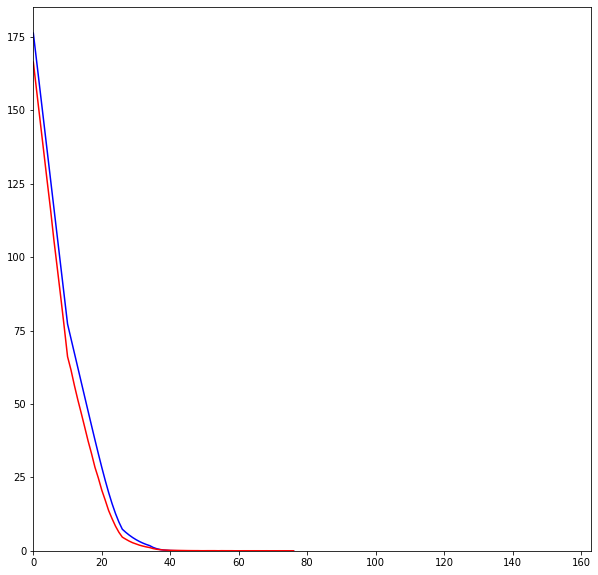

In [14]:
ax = plt.subplots(figsize=(10,10))
plt.plot(estimate, color="b")
plt.plot(askprice, color="r")
plt.ylim(0, None) # Or similarly "plt.ylim(0)"
plt.xlim(0, 163) # Or similarly "plt.ylim(0)"

In [83]:

import plotly.express as px
import plotly.graph_objects as go

#fig = go.Figure()
#fig.add_trace(go.Scatter(x= df_estimate["lastTradeDate"], y= df_estimate["Estimate"], name="Estimate", mode="lines"), 
#             range_x=['2021-08-10','2022-08-10'])
#fig.add_trace(go.Scatter(x=df_estimate["lastTradeDate"], y= askprice, name="askprice", mode="lines"))
#fig.update_layout(
 #   title="ICICI BANK stock prices", xaxis_title="Date", yaxis_title="Close"
#)
#fig.show()



df = df_estimate.sort_values(by= 'Binomial Estimate', ascending = False)

fig = px.line(df, x = dates, y = estimate, range_x=['2021-08-10','2022-08-10'], range_y=[None, 0])
fig.update_layout(xaxis_range=[0,None], xaxis_title = "Date")
fig.show()

#fig1 = px.line(x = date, y = estimate)
#fig1.show()




KeyError: 'Binomial Estimate'

In [84]:
df_estimate

df = df_estimate
df = df.sort_values(by = 'lastTradeDate')
fig = px.line(df, x = 'lastTradeDate', y = 'Black Scholes Estimate')
fig.show()

In [39]:
#git hub jawn https://github.com/kpmooney/numerical_methods_youtube/blob/master/binomial_model/Binomial%20Model.ipynb

import math

r = opt.calls



def Binomial(S0,K, r,T,N,sigma):
    #constants 
    u = math.exp(sigma)
    d = 1/u
    dt = T/N
    q = (math.exp(r*dt) - d) / (u-d)
    disc = np.exp(-r*dt)
    S = np.zeros(N+1)
    S[0] = S0*d**N
    for a in range(1, N+1):
        S[a] = S[a-1]*u/d
        
    C = np.zeros(N+1)
    for a in range(0, N+1):
        C[a] = max(0, S[a]-K)
    
    for i in np.arange(N, 0, -1):
        for a in range(0,i):
            C[a] = disc * ( q*C[a+1] + (1-q)*C[a] )
            
    return C[0]




bi_estimates = []


for i in range(0,163):
    bi_value = Binomial(S0 = 275.33,
                            r = 0.69,
                            K = r['strike'][i],
                            T = (datetime.datetime.strptime('2022-09-30', "%Y-%m-%d") - 
                             datetime.datetime.now()).days / 365,
                            sigma = np.sqrt(252) * df1['Returns'].std(),
                            N = 50)
    bi_estimates.append(bi_value)

In [35]:
# call option other


import math

r = opt.calls

sigma = np.sqrt(252) * df1['Returns'].std()



def Binomial(S0,K,u,d,r,T,N,sigma):
    #constants 
    dt = T/N
    q = (np.exp(r*dt) - d) / (u-d)
    disc = np.exp(-r*dt)
    
    S = np.zeros(N+1)
    S[0] = S0*d**N
    for a in range(1, N+1):
        S[a] = S[a-1]*u/d
        
    C = np.zeros(N+1)
    for a in range(0, N+1):
        C[a] = max(0, S[a]-K)
    
    for i in np.arange(N, 0, -1):
        for a in range(0,i):
            C[a] = disc * (q*C[a+1] + (1-q)*C[a])
            
    return C[0]



bi_estimates = []


for i in range(0,163):
    bi_value = Binomial(S0 = 275.33,
                            r = 0.69,
                            K = r['strike'][i],
                            T = (datetime.datetime.strptime('2022-09-30', "%Y-%m-%d") - 
                             datetime.datetime.now()).days / 365,
                            sigma = np.sqrt(252) * df1['Returns'].std(),
                            u = math.exp(sigma),
                            d = 1/u,
                            N = 3)
    bi_estimates.append(bi_value)

NameError: name 'u' is not defined

In [15]:
def Binomial(S0, r, K, N):
    # N = # of binomial layers
    # S0 = inital stock price
    # u = factor of upstep
    # r = risk free interest rate
    # K = Strike Price
    sigma = np.sqrt(252) * df1['Returns'].std()
    u = math.exp(sigma)
    d = 1 / u
    p = (1 + r - d) / (u - d)
    q = 1 - p

    # make stock price tree
    stock = np.zeros([N + 1, N + 1])
    for i in range(N + 1):
        for j in range(i + 1):
            stock[j, i] = S0 * (u ** (i - j)) * (d ** j)

    # Generate option prices recursively
    option = np.zeros([N + 1, N + 1])
    option[:, N] = np.maximum(np.zeros(N + 1), (stock[:, N] - K))
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            option[j, i] = (
                1 / (1 + r) * (p * option[j, i + 1] + q * option[j + 1, i + 1])
            )
    return option
    """
    d = 1/u 
    p = (1 + r - d) / (u - d)
    q = 1 - p
    
    # price tree
    stock = np.zeros([N + 1, N + 1])
    for n in range (N + 1):
        for i in range(n + 1):
            stock[i, n] = S0 * (u ** (n - i)) * (d ** i)
        
    option = np.zeros([N+1, N+1])
    option[:, N] = np.maximum(np.zeros(N + 1), (stock[:,N] - K))
    for n in range (N -1, -1, -1):
        for i in range (n + 1):
            option [i, n] = (
                1 / (1 + r) * (p * option[i, n + 1] + q * option[i + 1, n + 1])
            )                                                                                                        
    return option
                                                                           
for i in range(0,163):
    bi_value = Binomial(S0 = 275.33,
                            r = 0.69,
                            K = r['strike'][i],
                           # T = (datetime.datetime.strptime('2022-09-30', "%Y-%m-%d") - 
                            # datetime.datetime.now()).days / 365,
                            N = 3)
    bi_estimates.append(bi_value)                                                                          
    """              
                                                                           
                                                                           
                                                                        

In [91]:
bi_list = pd.DataFrame(data = bi_estimates, index = r.index)
bi_list['Binomial Estimate'] = bi_list[0]
del bi_list[0]
df_estimate = r.merge(bi_list, right_index = True, left_index = True)

bi_estimate = df_estimate['Binomial Estimate']
df_estimate['Binomial Estimate Error'] = ((askprice - bi_estimate)/bi_estimate)*100
bi_error = df_estimate['Binomial Estimate Error']
#df_estimate['Binomial Estimate Error'].describe()
print(df_estimate)

ValueError: Shape of passed values is (1793, 1), indices imply (163, 1)

/Users/ayush/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



count    163.000000
mean     -87.405123
std       25.294368
min     -100.000000
25%     -100.000000
50%      -99.981380
75%      -92.836036
max       -5.505692
Name: Binomial Estimate Error, dtype: float64

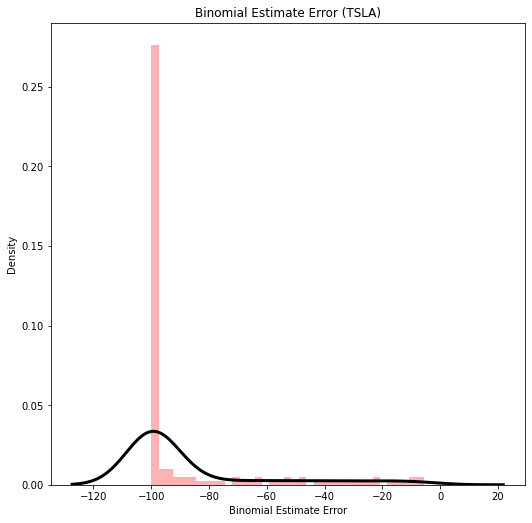

In [41]:
ax = plt.subplots(figsize=(8.5,8.5)),
ax = sns.distplot(bi_error, label = "Binomial Estimate Error x Density",
                  kde_kws={"color": "k", "lw": 3},
                  hist_kws={"histtype": "stepfilled", "linewidth": 3,
                            "alpha": 0.3, "color": "r"})
ax.set_title('Binomial Estimate Error (TSLA)')
#plt.ylim(None, .011)
#plt.xlim(-350,350)

bi_error.describe()



(0.0, 170.1)

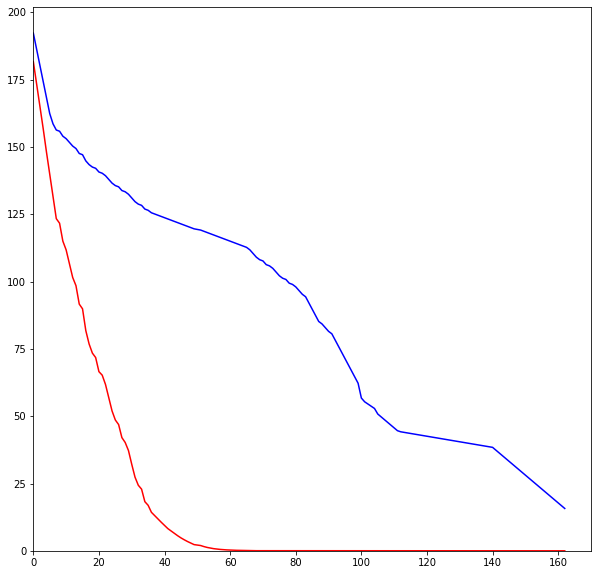

In [42]:
ax = plt.subplots(figsize=(10,10))
plt.plot(bi_estimate, color="b")
plt.plot(askprice, color="r")
plt.ylim(0, None) # Or similarly "plt.ylim(0)"
plt.xlim(0, None) # Or similarly "plt.ylim(0)"